In [1]:
import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent) +'/')
from utils.visualize import img_grid

from torchvision import transforms 

import numpy as np
import pandas as pd
import torchio as tio
import nibabel as nib

import ipywidgets as ipyw

import matplotlib.pyplot as plt
import SimpleITK as sitk
import torch
from torch import nn
from  torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance
import scipy
from sklearn import metrics
import json 
import imageio as iio

In [2]:
Path(os.getcwd()).parent.parent

PosixPath('/home/erik.ohara/macaw')

In [3]:
macaw_path = str(Path(os.getcwd()).parent.parent)
ukbb_path = '/home/erik.ohara/UKBB'
original_folder = '/work/forkert_lab/erik/T1_cropped'
generated_path = '/work/forkert_lab/erik/MACAW/cf_images/PCA_five_diff_res_hm'
ukbb_T1_warped_folder = '/work/forkert_lab/erik/T1_warped'
z_initial = 41
z_fim = 140
nsamples = 5
predictions_orig = '/home/erik.ohara/BrainAge/predictions_all-2.csv'
predictions_cf = '/home/erik.ohara/BrainAge/predictions_cf_five_res_hm.csv'
predictions_cf_56 = '/home/erik.ohara/BrainAge/predictions_cf_PCA_sklearn_56.csv'
predictions_cf_64 = '/home/erik.ohara/BrainAge/predictions_cf_PCA_sklearn_64.csv'
predictions_cf_71 = '/home/erik.ohara/BrainAge/predictions_cf_PCA_sklearn_71.csv'
train_path = '/work/forkert_lab/erik/T1_warped/train'
val_path = '/work/forkert_lab/erik/T1_warped/val'

In [ ]:
img_45 = iio.imread('/work/forkert_lab/erik/SPIE/45.png')
img_63 = iio.imread('/work/forkert_lab/erik/SPIE/63.png')

In [ ]:
img_45.shape

In [ ]:
# Calculate grayscale values
img_45 = 0.07 * img_45[:, :, 2] + 0.72 * img_45[:, :, 1] + 0.21 * img_45[:, :, 0]

# Convert to uint8 (8-bit) format
img_45 = img_45.astype(np.uint8)

In [ ]:
# Calculate grayscale values
img_63 = 0.07 * img_63[:, :, 2] + 0.72 * img_63[:, :, 1] + 0.21 * img_63[:, :, 0]

# Convert to uint8 (8-bit) format
img_63 = img_63.astype(np.uint8)

In [ ]:
img_45 = img_45/img_45.max()

In [ ]:
img_63 = img_63/img_63.max()

In [ ]:
plt.imshow(img_45,cmap='gray')
plt.show()

In [ ]:
plt.imshow(img_63,cmap='gray')
plt.show()

In [ ]:
diff = np.subtract(img_45,img_63)

In [ ]:
plt.imshow(diff, cmap='seismic',clim=(-1,1))
plt.axis('off')
plt.show()

In [4]:
data_path = ukbb_path + '/ukbb_img.csv'
df = pd.read_csv(data_path,low_memory=False)

In [5]:
df_train = pd.DataFrame(columns=df.columns)
for each_file in os.listdir(train_path):
    if '.nii' in each_file:
        file_id = each_file.split('.nii')[0]
        df_train = pd.concat([df[df['eid'] == int(file_id)],df_train.loc[:]]).reset_index(drop=True)
df_train.sort_values(by=['eid'], inplace=True)

In [6]:
df_orig = pd.read_csv(predictions_orig)
df_cf = pd.read_csv(predictions_cf)
df_cf_56 = pd.read_csv(predictions_cf_56)
df_cf_64 = pd.read_csv(predictions_cf_64)
df_cf_71 = pd.read_csv(predictions_cf_71)

In [ ]:
df_orig['ABSError'].describe()

In [ ]:
df_cf['ABSError'].describe()

In [ ]:
df_cf_56['Prediction'].describe()

In [ ]:
df_cf_64['Prediction'].describe()

In [ ]:
df_cf_71['Prediction'].describe()

In [ ]:
df_cf_56_64_71 = pd.concat([df_cf_56,df_cf_64,df_cf_71])

In [ ]:
df_cf_56_64_71

In [ ]:
# Getting the best and the worst 
df_cf.nlargest(nsamples, 'ABSError')

In [ ]:
df_cf.nsmallest(nsamples, 'ABSError')

In [6]:
#subjects_eid_worst = df_cf.nlargest(5, 'ABSError')['EID']
#subjects_eid_best = df_cf.nsmallest(5, 'ABSError')['EID']
subjects_eid_best = [1052625,4431304,2582745,4518612,3139804]

In [7]:
# Getting the generated best and worst images
cf_age_best = np.array([])
cf_sex_best = np.array([])
images_generated_best = []
files_generated_best = []
for individual in tqdm(subjects_eid_best):
    for file in os.listdir(generated_path):
        if '.nii' in file:
            splits = file.split("_")
            subject_eid = int(splits[0])
            if int(subject_eid) == individual:
                files_generated_best.append(file)
                age = splits[1]
                sex = splits[2].split(".")[0]
                cf_age_best = np.append(cf_age_best, age)
                cf_sex_best = np.append(cf_sex_best, sex)
                image_load = nib.load(os.path.join(generated_path, file)).get_fdata()
                images_generated_best.append(image_load)
            
images_generated_best = np.array(images_generated_best)
'''            
cf_age_worst = np.array([])
cf_sex_worst = np.array([])
images_generated_worst = []
files_generated_worst = []
for individual in tqdm(subjects_eid_worst):
     for file in os.listdir(generated_path):
        if '.nii' in file:
            splits = file.split("_")
            subject_eid = int(splits[0])
            if int(subject_eid) == individual:
                files_generated_worst.append(file)
                age = splits[1]
                sex = splits[2].split(".")[0]
                cf_age_worst = np.append(cf_age_worst, age)
                cf_sex_worst = np.append(cf_sex_worst, sex)
                image_load = nib.load(os.path.join(generated_path, file)).get_fdata()
                images_generated_worst.append(image_load)

images_generated_worst = np.array(images_generated_worst)
'''

  0%|          | 0/5 [00:00<?, ?it/s]

'            \ncf_age_worst = np.array([])\ncf_sex_worst = np.array([])\nimages_generated_worst = []\nfiles_generated_worst = []\nfor individual in tqdm(subjects_eid_worst):\n     for file in os.listdir(generated_path):\n        if \'.nii\' in file:\n            splits = file.split("_")\n            subject_eid = int(splits[0])\n            if int(subject_eid) == individual:\n                files_generated_worst.append(file)\n                age = splits[1]\n                sex = splits[2].split(".")[0]\n                cf_age_worst = np.append(cf_age_worst, age)\n                cf_sex_worst = np.append(cf_sex_worst, sex)\n                image_load = nib.load(os.path.join(generated_path, file)).get_fdata()\n                images_generated_worst.append(image_load)\n\nimages_generated_worst = np.array(images_generated_worst)\n'

In [8]:
# Getting the original best and worst images
images_original_best = []
real_age_best = []
real_sex_best = []
for individual in tqdm(subjects_eid_best):
    individual = int(individual)
    real_age_best.append(df[df["eid"] == individual]["Age"].item())
    real_sex_best.append(df[df["eid"] == individual]["Sex"].item())
    image_load = nib.load(os.path.join(original_folder, str(individual) + ".nii.gz")).get_fdata()
    images_original_best.append(image_load)
real_age_best = np.array(real_age_best)
real_sex_best = np.array(real_sex_best)
images_original_best = np.array(images_original_best)
print(len(images_original_best))
'''
images_original_worst = []
real_age_worst = []
real_sex_worst = []
for individual in tqdm(subjects_eid_worst):
    individual = int(individual)
    real_age_worst.append(df[df["eid"] == individual]["Age"].item())
    real_sex_worst.append(df[df["eid"] == individual]["Sex"].item())
    image_load = nib.load(os.path.join(original_folder, str(individual) + ".nii.gz")).get_fdata()
    images_original_worst.append(image_load)
real_age_worst = np.array(real_age_worst)
real_sex_worst = np.array(real_sex_worst)
images_original_worst = np.array(images_original_worst)
print(len(images_original_worst))
'''

  0%|          | 0/5 [00:00<?, ?it/s]

5


'\nimages_original_worst = []\nreal_age_worst = []\nreal_sex_worst = []\nfor individual in tqdm(subjects_eid_worst):\n    individual = int(individual)\n    real_age_worst.append(df[df["eid"] == individual]["Age"].item())\n    real_sex_worst.append(df[df["eid"] == individual]["Sex"].item())\n    image_load = nib.load(os.path.join(original_folder, str(individual) + ".nii.gz")).get_fdata()\n    images_original_worst.append(image_load)\nreal_age_worst = np.array(real_age_worst)\nreal_sex_worst = np.array(real_sex_worst)\nimages_original_worst = np.array(images_original_worst)\nprint(len(images_original_worst))\n'

In [9]:
#images_generated_worst.shape

In [10]:
images_original_best.shape

(5, 150, 150, 100)

In [11]:
#cropping original image
'''
generated_shape = images_generated_best[0].shape
original_shape = images_original_best[0].shape
x_initial = int((original_shape[0] - generated_shape[0])/2)
x_fim = x_initial +  generated_shape[0]
y_initial = int((original_shape[1] - generated_shape[1])/2)
y_fim = y_initial +  generated_shape[1]
images_original_best = np.array([image[x_initial:x_fim,y_initial:y_fim,z_initial:z_fim+1] for image in images_original_best])
images_original_worst = np.array([image[x_initial:x_fim,y_initial:y_fim,z_initial:z_fim+1] for image in images_original_worst])  
'''

'\ngenerated_shape = images_generated_best[0].shape\noriginal_shape = images_original_best[0].shape\nx_initial = int((original_shape[0] - generated_shape[0])/2)\nx_fim = x_initial +  generated_shape[0]\ny_initial = int((original_shape[1] - generated_shape[1])/2)\ny_fim = y_initial +  generated_shape[1]\nimages_original_best = np.array([image[x_initial:x_fim,y_initial:y_fim,z_initial:z_fim+1] for image in images_original_best])\nimages_original_worst = np.array([image[x_initial:x_fim,y_initial:y_fim,z_initial:z_fim+1] for image in images_original_worst])  \n'

In [12]:
images_original_normalized_best = np.copy(images_original_best)
#images_original_normalized_worst = np.copy(images_original_worst)
images_generated_normalized_best = np.copy(images_generated_best)
#images_generated_normalized_worst = np.copy(images_generated_worst)

In [13]:
# Normalizing
for one_image in images_original_normalized_best:
    maxv = np.max(one_image[:,:,:])
    one_image[:,:,:] = ((one_image[:,:,:]) / maxv)
'''
for one_image in images_original_normalized_worst:
    maxv = np.max(one_image[:,:,:])
    one_image[:,:,:] = ((one_image[:,:,:]) / maxv)
'''

'\nfor one_image in images_original_normalized_worst:\n    maxv = np.max(one_image[:,:,:])\n    one_image[:,:,:] = ((one_image[:,:,:]) / maxv)\n'

In [14]:
# Normalizing Generated
for one_image in images_generated_normalized_best:
    maxv = np.max(one_image[:,:,:])
    one_image[:,:,:] = ((one_image[:,:,:]) / maxv)
'''
for one_image in images_generated_normalized_worst:
    maxv = np.max(one_image[:,:,:])
    one_image[:,:,:] = ((one_image[:,:,:]) / maxv)
'''

'\nfor one_image in images_generated_normalized_worst:\n    maxv = np.max(one_image[:,:,:])\n    one_image[:,:,:] = ((one_image[:,:,:]) / maxv)\n'

## Best results - Difference map

In [15]:
subjects_eid_best

[1052625, 4431304, 2582745, 4518612, 3139804]

In [16]:
titles_cf_best = [f'Age:{a}, Sex:{s}' for a,s in zip(cf_age_best,cf_sex_best)]
real_sex_best_2 = ['M' if round(s) else 'F' for s in real_sex_best]
titles_real_best = [f'Age:{a}, Sex:{s}' for a,s in zip(real_age_best,real_sex_best_2)]

In [17]:
cf_sex_best

array(['Female', 'Female', 'Female', 'Male', 'Female'], dtype='<U32')

In [18]:
real_sex_best_2

['F', 'F', 'F', 'M', 'F']

In [19]:
# Mapping the difference
diff_best = [np.subtract(a,s) for a,s in zip(images_original_normalized_best,images_generated_normalized_best)]

In [20]:
diff_best[4].max()

0.26912232322974144

In [23]:
def plot_slice_best(z_slice):
    order_slice = z_slice - z_initial
    plt.rcParams["figure.figsize"] = (20,5)
    img_grid([np.rot90(one_image[:,:,order_slice]) for one_image in images_original_normalized_best],cols=nsamples,titles=titles_real_best)
    img_grid([np.rot90(one_image[:,:,order_slice]) for one_image in images_generated_normalized_best],cols=nsamples,titles=titles_cf_best)
    img_grid([np.rot90(one_image[:,:,order_slice]) for one_image in diff_best],cols=nsamples, cmap='seismic', clim=(-0.5,0.5))

In [24]:
ipyw.interact(plot_slice_best, 
              z_slice=ipyw.IntSlider(min=z_initial, max=z_fim, step=1, continuous_update=False, description='Image Slice:'))

interactive(children=(IntSlider(value=41, continuous_update=False, description='Image Slice:', max=140, min=41…

<function __main__.plot_slice_best(z_slice)>

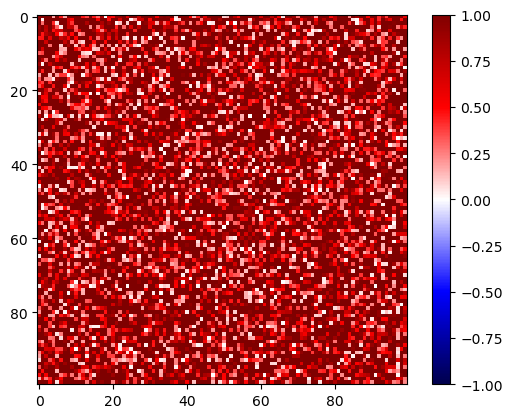

In [2]:
# Generate some example data (replace this with your actual data)
data = np.random.random((100, 100)) * 2
#data[data < 0.5] = 0.5

# Create the plot using imshow and the 'seismic' colormap
plt.imshow(data, cmap='seismic', vmin=-1, vmax=1)

# Add a color bar
plt.colorbar()

# Show the plot
plt.show()

In [ ]:
# save diff files
import nibabel as nib

diff_best = np.array(diff_best)

for idx, diff_image in enumerate(diff_best):
    new_image = nib.Nifti1Image(diff_best, affine=np.eye(4))
    nib.save(new_image,'/home/erik.ohara/diff_maps/' + str(subjects_eid_best[idx]) + '.nii.gz')

## Worst results - Difference map

In [ ]:
subjects_eid_worst

In [ ]:
titles_cf_worst = [f'Age:{a}, Sex:{s}' for a,s in zip(cf_age_worst,cf_sex_worst)]
real_sex_worst_2 = ['M' if round(s) else 'F' for s in real_sex_worst]
titles_real_worst = [f'Age:{a}, Sex:{s}' for a,s in zip(real_age_worst,real_sex_worst_2)]

In [ ]:
# Mapping the difference
diff_worst = [np.subtract(a,s) for a,s in zip(images_original_normalized_worst,images_generated_normalized_worst)]

In [ ]:
def plot_slice_worst(z_slice):
    order_slice = z_slice - z_initial
    plt.rcParams["figure.figsize"] = (20,5)
    img_grid([one_image[:,:,order_slice] for one_image in images_original_normalized_worst],cols=nsamples,titles=titles_real_worst)
    img_grid([one_image[:,:,order_slice] for one_image in images_generated_normalized_worst],cols=nsamples,titles=titles_cf_worst)
    img_grid([one_image[:,:,order_slice] for one_image in diff_worst],cols=nsamples, cmap='seismic', clim=(-1,1))

In [ ]:
ipyw.interact(plot_slice_worst, 
              z_slice=ipyw.IntSlider(min=z_initial, max=z_fim, step=1, continuous_update=False, description='Image Slice:'))

## Analsying the errors

In [7]:
df_orig.rename(columns={"Age": "Original_Age", "Prediction": "Original_Prediction"},inplace=True)

In [8]:
df_cf_analysis = df_cf.set_index('EID').join(
                                            df_orig[['EID',
                                                     'Original_Age',
                                                     'Original_Prediction']].set_index('EID'), 
                                                                                        on='EID', 
                                                                                        how='left')

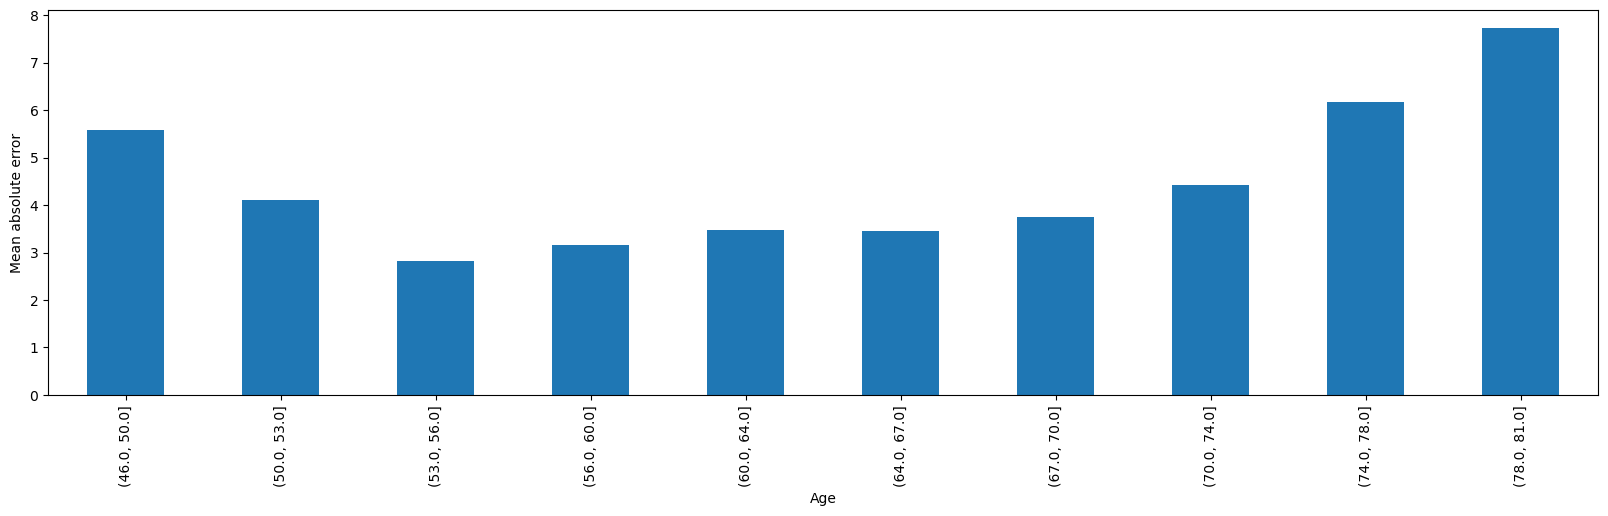

In [11]:
# Create bins for the x column
plt.rcParams["figure.figsize"] = (20,5)
bins = pd.cut(df_cf_analysis['Age'], bins=10, precision=0)

# Group the dataframe by the bins and calculate the mean of the y column
grouped = df_cf_analysis.groupby(bins)['ABSError'].mean()
plt.ylabel("Mean absolute error")
# Plot the resulting dataframe
grouped.plot(kind='bar')
plt.show()

In [ ]:
grouped

In [ ]:
df_train['Age'] = df_train['Age'].astype(int)

In [ ]:
ax = df_train["Age"].plot.hist(bins=10)